In [82]:
import os
import sys
import pandas as pd
import yaml 
from matplotlib import pyplot as plt

with open("../../config.yaml.local", "r") as f:
    LOCAL_CONFIG = yaml.safe_load(f)
with open("../../config.yaml", "r") as f:
    CONFIG = yaml.safe_load(f)
sys.path.append("../python")

import globals

RAW_DATA_PATH = LOCAL_CONFIG["RAW_DATA_PATH"]


In [83]:
users_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "users.parquet"))
item_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "item.parquet"))
itemact_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "itemact.parquet"))
invoice_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "invoice.parquet"))
withdrawal_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "withdrawal.parquet"))
invoiceforward_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "invoiceforward.parquet"))
wallet_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "wallet.parquet"))
walletprotocol_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "walletprotocol.parquet"))


In [84]:
# summary
n_users = len(users_df)
n_items = len(item_df)
first_date = item_df['created_at'].min().strftime('%Y-%m-%d')
last_date = item_df['created_at'].max().strftime('%Y-%m-%d')
print(f"{n_users:,.0f} users, {n_items:,.0f} items from {first_date} to {last_date}")

30,737 users, 1,240,214 items from 2021-06-11 to 2025-10-05


In [85]:
# first autowithdraw date
idx = (withdrawal_df['autoWithdraw']==True) & (withdrawal_df['status']=='CONFIRMED')
autowithdraw_df = withdrawal_df.loc[idx].groupby('userId').agg(
    first_auto_withdraw = ('created_at', 'min')
).reset_index()

In [86]:
# first sent sats date
my_df = itemact_df.merge(
    invoice_df[['id','confirmedAt']].rename(columns={'id':'invoiceId'}),
    how='left', on='invoiceId'
)
idx = (my_df['invoiceId'].notnull()) & (my_df['confirmedAt'].notnull()) & (my_df['act'].isin(['TIP']))
sentsats_df = my_df.loc[idx].groupby('userId').agg(
    first_sent_sats = ('created_at', 'min')
).reset_index()


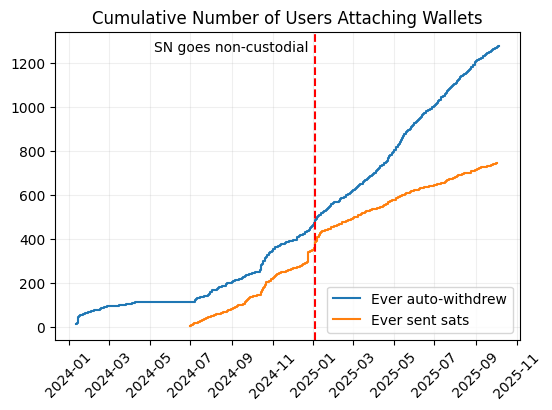

In [87]:
# plot cumulative wallet attaches

plot_df1 = attach_df['first_auto_withdraw'].dt.date.value_counts().sort_index().cumsum()
plot_df2 = sentsats_df['first_sent_sats'].dt.date.value_counts().sort_index().cumsum()

plt.figure(figsize=(6,4))
plt.step(plot_df1.index, plot_df1.values, where='post', label='Ever auto-withdrew')
plt.step(plot_df2.index, plot_df2.values, where='post', label='Ever sent sats')
plt.axvline(globals.nc_date, color='red', linestyle='--')
plt.text(globals.nc_date - pd.to_timedelta(10,unit='D'), 1250, 'SN goes non-custodial', ha='right')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.title("Cumulative Number of Users Attaching Wallets")
plt.grid(alpha=0.2)
plt.show()